### Section 1

In [ ]:
import os

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd


def uniform_to_normal(z):

    ###  Map a value from ~U(-1, 1) to ~N(0, 1)

    norm = stats.norm(0, 1)
    return norm.ppf((z+1)/2)

def generate_noise(samples, dimensions=2):

    ###  Generate a matrix of random noise in [-1, 1] with shape (samples, dimensions) 

    return np.random.uniform(-1, 1, (samples, dimensions))


def build_generator(LATENT_DIM, output_dim):

    ###  Build a generator mapping (R, R) to ([-1,1], [-1,1])

    input_layer = layers.Input((LATENT_DIM,))
    X = input_layer
    X = layers.Dense(32 ,activation='tanh')(X)
    output_layer = layers.Dense(output_dim)(X)
    G = Model(input_layer, output_layer)
    return G


def build_discriminator(dim):

    ###  Build a discriminator mapping (R, R) to [0, 1]

    input_layer = layers.Input((dim,))
    X = input_layer
    X = layers.Dense(32)(X)
    X = layers.LeakyReLU(0.1)(X)
    output_layer = layers.Dense(1, activation='sigmoid')(X)
    D = Model(input_layer, output_layer)
    D.compile(Adam(learning_rate=0.002, beta_1=0.5),loss='binary_crossentropy',metrics=['accuracy'])
    return D

def build_GAN(G, D, LATENT_DIM):

    ### Given a generator and a discriminator, build a GAN

    D.trainable = False
    input_layer = layers.Input((LATENT_DIM,))
    X = G(input_layer)
    output_layer = D(X)
    GAN = Model(input_layer, output_layer)
    GAN.compile(Adam(learning_rate=0.001, beta_1=0.5),loss='binary_crossentropy',metrics=['accuracy'])
    return GAN

In [ ]:
NUM_BATCHES = 1000
BATCH_SIZE = 4000
PLOT_EVERY = 1
GRID_RESOLUTION = 400
LATENT_DIM = 2
### Building Generator
G = build_generator(LATENT_DIM, 2)
### Building Discriminator
D = build_discriminator(2)
### Building GAN by connecting Generator and discriminator together
GAN = build_GAN(G, D, LATENT_DIM)

In [ ]:
step_count = []
D_accuracy = []
G_accuracy = []
D_loss = []
G_loss = []
count = 0
for step in range(NUM_BATCHES):
  ### Train discriminator
  D.trainable = True
  real_data = uniform_to_normal(generate_noise(BATCH_SIZE // 2, LATENT_DIM))  
  fake_data = G.predict(generate_noise(BATCH_SIZE // 2, LATENT_DIM), batch_size=BATCH_SIZE // 2)
  data = np.concatenate((real_data, fake_data), axis=0)
  real_labels = np.ones((BATCH_SIZE // 2, 1))
  fake_labels = np.zeros((BATCH_SIZE // 2, 1))
  labels = np.concatenate((real_labels, fake_labels), axis=0)
  D__loss, D__accuracy = D.train_on_batch(data, labels)
  ### Train generator
  D.trainable = False
  noise = generate_noise(BATCH_SIZE, LATENT_DIM)
  labels = np.ones((BATCH_SIZE, 1))
  G__loss, G__accuracy = GAN.train_on_batch(noise, labels)
  ### appending discriminator's loss and accuracy to a list for evaluation
  step_count.append(step)
  D_loss.append(D__loss)
  D_accuracy.append(D__accuracy)
  ### appending generator's loss and accuracy to a list for evaluation
  G_loss.append(G__loss)
  G_accuracy.append(G__accuracy)

(0.0, 60.0)

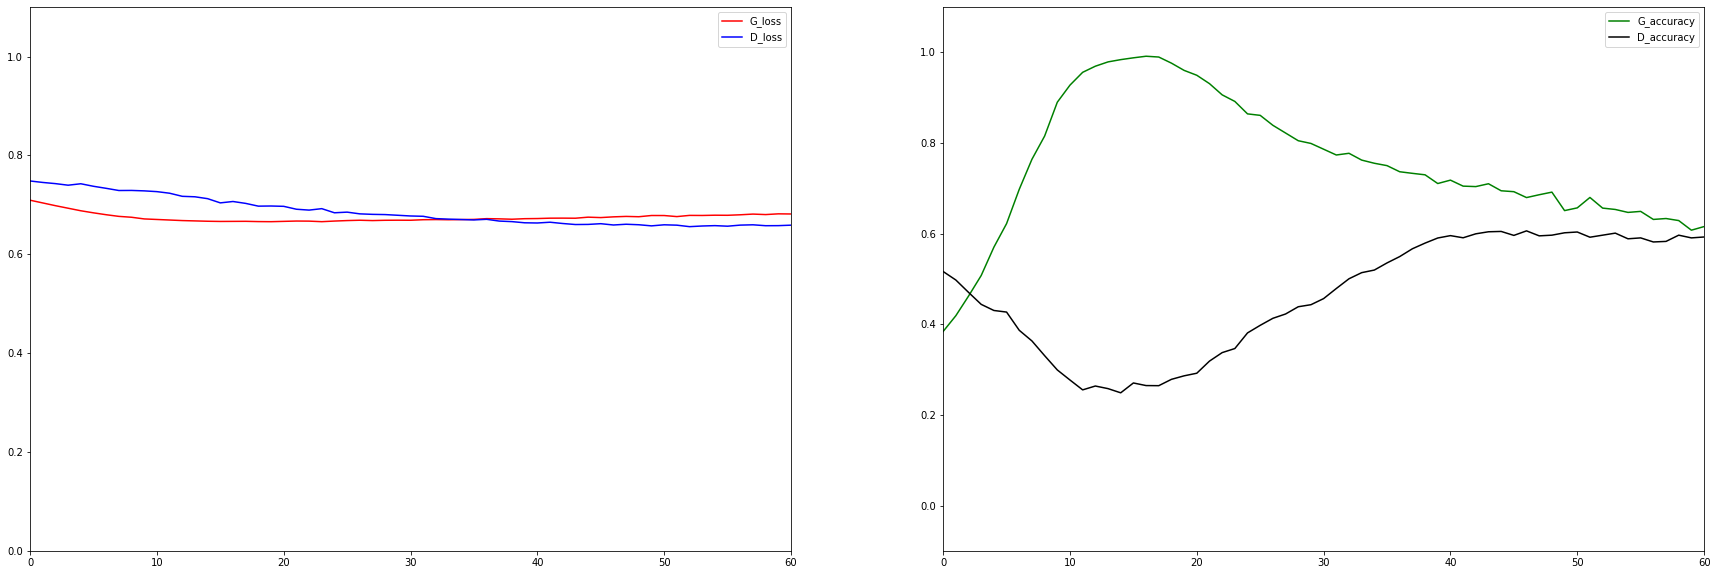

In [ ]:
### plot loss and accuracy
plt.figure(figsize=(30,10))
plt.subplot(121)
plt.plot(G_loss,'red')
plt.ylim([0,1.1])
plt.xlim([0,60])
plt.plot(D_loss,'blue')
plt.ylim([0,1.1])
plt.xlim([0,60])
plt.legend(['G_loss','D_loss'])
plt.subplot(122)
plt.plot(G_accuracy,'Green')
plt.ylim([0,1.1])
plt.xlim([0,60])
plt.plot(D_accuracy,'black')
plt.legend(['G_accuracy','D_accuracy'])
plt.ylim([-0.1,1.1])
plt.xlim([0,60])

Text(0, 0.5, 'Probability Density')

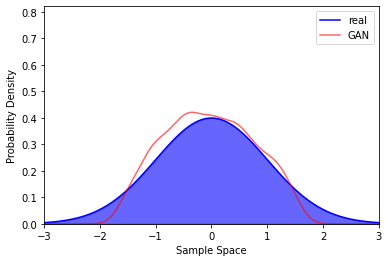

In [ ]:
### making a standars normal distribution
x_vals = np.linspace(-3, 3, 301)
y_vals = stats.norm(0,1).pdf(x_vals)
plt.plot(x_vals, y_vals, color='blue', label='real')
plt.fill_between(x_vals, np.zeros(len(x_vals)), y_vals, color='blue', alpha=0.6)
### Testing Generator network to see if output is gaussian or not
test_noise = generate_noise(1000, LATENT_DIM)
fake_samples = G.predict(test_noise, batch_size=len(test_noise))
s = pd.Series(fake_samples.flatten())
ax = s.plot.kde(c='red', alpha=0.6, label='GAN')
plt.xlim([-3,3])
plt.ylim([0,0.82])
plt.legend(loc=1)
plt.xlabel('Sample Space')
plt.ylabel('Probability Density')

بله توزیع بدست آمده تطابق مناسبی با توزیع گاوسی دارد.

### Section 2

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

In [ ]:
# load the Fashion MNIST dataset 
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

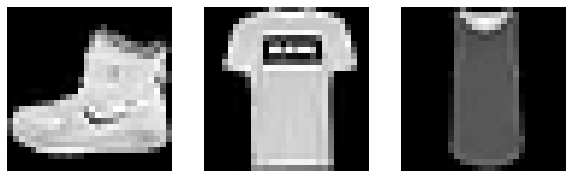

In [ ]:
### plot multiple object 
plt.figure(figsize = (10,5))
plt.subplot(131)
plt.imshow(train_images[0], cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(train_images[1], cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(train_images[2], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
### reshape 
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
### normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [ ]:
def build_generator():
    # create a Sequential model 
    model = Sequential(name="generator")
    'I have manipulated number of neurons for having less computational complexity and lower runtime'
    'also I recieved better results using these new layers'
    # FullyConnected => BatchNormalization => LeakyRelu layers
    model.add(layers.Dense(7 * 7 * 512, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # reshape the output of the previous layer to 3D form
    model.add(layers.Reshape((7, 7, 512)))

    # transpose Conv2D => BatchNormalization => LeakyRelu layers
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # transpose Conv2D => BatchNormalization => LeakyRelu layers
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # final layer: Conv2D with sigmoid activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="sigmoid"))

    # return the generator model
    return model

In [ ]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)
    'I have manipulated number of neurons for having less computational complexity and lower runtime'
    'also I recieved better results using these new layers'
    # Conv2D => BatchNormalization => LeakyRelu layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Conv2D => BatchNormalization => LeakyRelu layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [ ]:
# build the generator model
generator = build_generator()

In [ ]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1)

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [ ]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6609 - g_loss: 0.8456

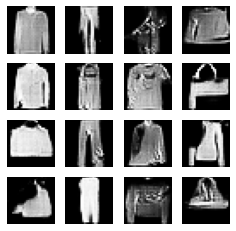

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6609 - g_loss: 0.8456
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6605 - g_loss: 0.8503

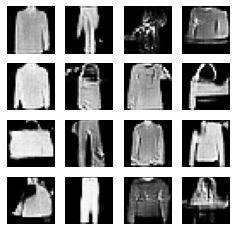

1875/1875 [==============================] - 50s 27ms/step - d_loss: 0.6605 - g_loss: 0.8503
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6583 - g_loss: 0.8565

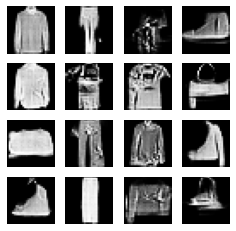

1875/1875 [==============================] - 50s 27ms/step - d_loss: 0.6583 - g_loss: 0.8565
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6592 - g_loss: 0.8657

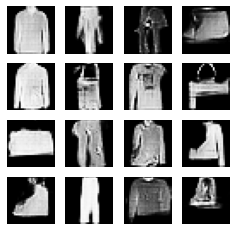

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6592 - g_loss: 0.8657
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6569 - g_loss: 0.8676

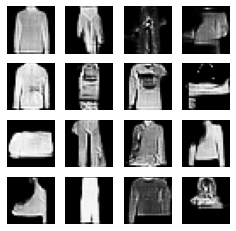

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6569 - g_loss: 0.8676
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6548 - g_loss: 0.8684

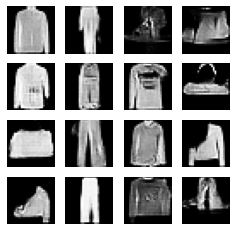

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6548 - g_loss: 0.8684
Epoch 7/10
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6563 - g_loss: 0.8709

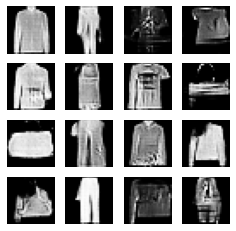

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6563 - g_loss: 0.8709
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6558 - g_loss: 0.8754

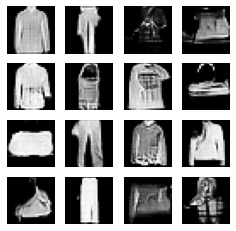

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6558 - g_loss: 0.8754
Epoch 9/10
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6563 - g_loss: 0.8717

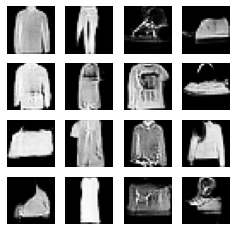

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6563 - g_loss: 0.8717
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6552 - g_loss: 0.8690

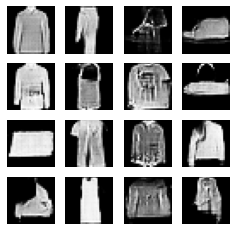

1875/1875 [==============================] - 51s 27ms/step - d_loss: 0.6552 - g_loss: 0.8690


In [ ]:
NUM_EPOCHS = 10 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

each epoch's result is provided above and we reached to clear images in 10th epoch of learning process.

---------------------------------
